<h1 style="font-size:350%;text-align:center;border-radius: 50px 50px;padding: 15px;color:black;">Urban Sound Classification using Deep Learning</h1>

![](https://miro.medium.com/max/1400/1*7YbBTqwF2dMAuQwOrD_hXQ.png)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense,GlobalAveragePooling2D, Dropout

In [2]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2022-10-06 16:17:47--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  29.3MB/s    in 3m 28s  

2022-10-06 16:21:16 (27.7 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [22]:
#/content/UrbanSound8K
path='/content/UrbanSound8K/audio/'
path_csv = '/content/UrbanSound8K/metadata/UrbanSound8K.csv'
data = pd.read_csv(path_csv)
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [5]:
data.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [6]:
data.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [23]:
data['file_path'] = path+'fold'+data.fold.astype(str)+'/'+data['slice_file_name']
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,file_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/content/UrbanSound8K/audio/fold5/100032-3-0-0...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/content/UrbanSound8K/audio/fold5/100263-2-0-1...


In [24]:
df = data[['file_path','class']]
df.head()

,file_path,class
0,/content/UrbanSound8K/audio/fold5/100032-3-0-0...,dog_bark
1,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,children_playing
2,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,children_playing
3,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,children_playing
4,/content/UrbanSound8K/audio/fold5/100263-2-0-1...,children_playing


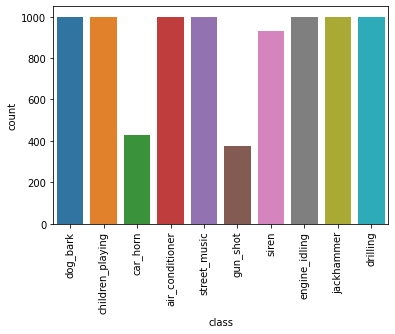

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [25]:
sns.countplot(x='class', data=df)
plt.xticks(rotation=90);
plt.show()
df['class'].value_counts()

In [26]:
df.columns

Index(['file_path', 'class'], dtype='object')

In [27]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    return mfccs_processed

In [28]:
features = []
for index, row in df.iterrows():
    file_name = str(row['file_path'])
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])  

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [29]:
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [30]:
featuresdf.head()

,feature,class_label
0,"[-214.95764, 70.502464, -130.70279, -53.116936...",dog_bark
1,"[-423.7311, 109.2299, -52.872597, 60.827538, 0...",children_playing
2,"[-458.52844, 121.35432, -46.535675, 51.969467,...",children_playing
3,"[-413.63254, 101.61351, -35.43868, 53.047146, ...",children_playing
4,"[-446.38693, 113.68634, -52.4572, 60.349724, 2...",children_playing


In [31]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

In [32]:
X.shape, y.shape

((8732, 40), (8732,))

In [33]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [35]:
x_train.shape[1]

40

**Model Creation** 





In [36]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [38]:
### No of classes
num_labels=y.shape[1]

In [40]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [45]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [46]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
195/219 [=========================>....] - ETA: 0s - loss: 13.4853 - accuracy: 0.1293
Epoch 1: val_loss improved from inf to 2.27673, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 12.3819 - accuracy: 0.1316 - val_loss: 2.2767 - val_accuracy: 0.1425
Epoch 2/100
195/219 [=========================>....] - ETA: 0s - loss: 2.6680 - accuracy: 0.1357
Epoch 2: val_loss improved from 2.27673 to 2.25705, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 2.6343 - accuracy: 0.1351 - val_loss: 2.2570 - val_accuracy: 0.1334
Epoch 3/100
212/219 [============================>.] - ETA: 0s - loss: 2.3206 - accuracy: 0.1340
Epoch 3: val_loss improved from 2.25705 to 2.20512, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 2.3192 - accuracy: 0.1340 - val_loss: 2.2051 - val_accuracy: 0.16

In [47]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.779049813747406
